In [206]:
import pandas

pandas.set_option('display.max_rows', None, 'display.max_columns', None)
spending_data = pandas.read_csv('../data/csv/cabinet_member_spending.csv')
trunc = spending_data[['Nominee', 'Votes For', 'Votes Against']]

### First, we will import the data and process it to hold the percentages we need

In [207]:
REPUBLICAN_PRESIDENTS = ('George W. Bush', 'Donald Trump')
DEMOCRATIC_PRESIDENTS = ('Barack Obama', )
REPUBLICAN_PARTY = 0
DEMOCRATIC_PARTY = 1

normalized_spending_data = pandas.DataFrame(columns=['party', 'vote_ratio', 'domestic_spending_ratio'])
normalized_spending_data = normalized_spending_data.assign(
    party=spending_data['President'].map(lambda president: REPUBLICAN_PARTY if president in REPUBLICAN_PRESIDENTS else DEMOCRATIC_PARTY),
    vote_ratio=spending_data['Votes For']/(spending_data['Votes For'] + spending_data['Votes Against']),
    domestic_spending_ratio=spending_data['domestic_spending']/(spending_data['domestic_spending'] + spending_data['foreign_spending'])
)

### Now, we will plot all of the data as a scatter plot

In [208]:
import matplotlib.ticker
from matplotlib import pyplot as plt


# Makes a scatter plot on the given axes with the given spending data, which expects that we have a vote_ratio, domestic_spending_ratio, and party field
def make_spending_scatter_plot(axes: plt.Axes, spending_data: pandas.DataFrame) -> None:
    axes.set_title('Spending vs Popularity in Senate')
    axes.set_xlabel('Percentage of Votes for Candidate')
    axes.set_ylabel('Percentage of Agency Domestic Spending to Total Agency Spending')
    axes.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    axes.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    plot_entities = [
        {
            'party': REPUBLICAN_PARTY,
            'color': 'red',
            'label': 'Republican Cabinet Member'
        },
        {
            'party': DEMOCRATIC_PARTY,
            'color': 'blue',
            'label': 'Democratic Cabinet Member'
        },
    ]

    plotted_entities = []
    for entity in plot_entities:
        entity_data = spending_data[spending_data['party'] == entity['party']]
        axes.scatter(
            entity_data['vote_ratio'] * 100,
            entity_data['domestic_spending_ratio'] * 100,
            c=entity['color'],
            label=entity['label'],
        )
    axes.legend()

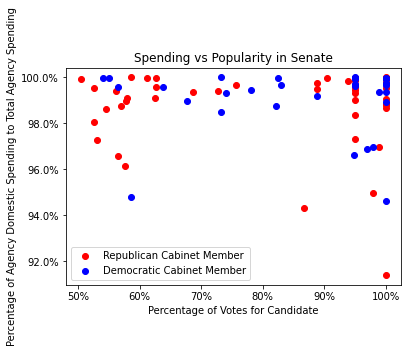

In [209]:
from matplotlib import pyplot as plt
import math

# It's reasonable to assume about 95% of senators voted positively if a voice vote was used
VOICE_VOTE_APPROXIMATION = 0.95


# Normalize the data so NaN (i.e. voice votes) values get a sane default
vote_normalized_spending_data = normalized_spending_data.copy()
vote_normalized_spending_data['vote_ratio'] = [VOICE_VOTE_APPROXIMATION if math.isnan(ratio) else ratio for ratio in vote_normalized_spending_data['vote_ratio']]

scatter_figure = plt.figure()
scatter_plot = scatter_figure.add_subplot(1, 1, 1)
make_spending_scatter_plot(scatter_plot, vote_normalized_spending_data)

plt.show()

### Running a clustering algorithm on the data and plotting the points, we notice that regardless of popularity, the centers of the spending are quite similar w.r.t. spending, regardless of party or popularity.

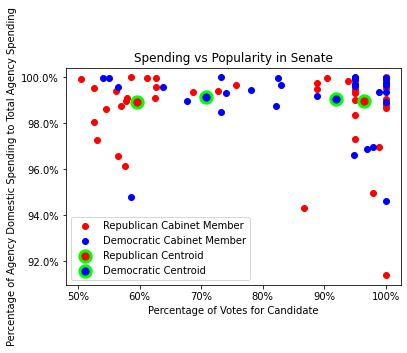

In [210]:
import sklearn.cluster
import math
import numpy
import itertools


clustering_model = sklearn.cluster.MeanShift()
clustering_model.fit(vote_normalized_spending_data)
centers = clustering_model.cluster_centers_

scatter_figure = plt.figure()
scatter_plot = scatter_figure.add_subplot(1, 1, 1)
make_spending_scatter_plot(scatter_plot, vote_normalized_spending_data)

# Sort the centers by their party, to allow itertools.groupby to work correctly
centers = centers[numpy.argsort(centers[:,0])]
# Iterate over the centers, grouping by party
for party_identifier, party_centers in itertools.groupby(centers, key=lambda x: x[0]):
    # Scale the party centers so that they're out of 100
    scaled_party_centers = [[item * 100 if i > 0 else item for i, item in enumerate(center)] for center in party_centers]

    # Plot the result
    scatter_plot.scatter(
        [center[1] for center in scaled_party_centers],
        [center[2] for center in scaled_party_centers],
        s=128,
        edgecolors='lime', 
        facecolors=('red' if party_identifier == REPUBLICAN_PARTY else 'blue'),
        linewidths=3,
        label=f'{"Republican" if party_identifier == REPUBLICAN_PARTY else "Democratic"} Centroid'
    )   

scatter_plot.legend()
plt.show()

### Running a Pearson Correlation test, we see that the vote ratio is hardly correlated to the domestic spending ratio.

In [211]:
import scipy.stats

r, p = scipy.stats.pearsonr(vote_normalized_spending_data['vote_ratio'], vote_normalized_spending_data['domestic_spending_ratio'])

print(f'Pearson r-value: {r:0.3}\nPearson p-value: {p:0.3}')

Pearson r-value: 0.0246
Pearson p-value: 0.822
